# State Estimation, Forward Only

In this demo, the goal is to filter noisy observations by performing on-line inference with a generative state-space model (SSM).

Let `x_t_min` be the previous state of the system, `x_t` the current state, `u` a constant system input and `y_t` the noisy observation of `x_t`:

\begin{align*}
    u &= 1\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The SSM can be represented by the following Forney-style factor graph, where the pictured section is chained over time:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

For on-line (forward-only) estimation in ForneyLab, it suffices to build a single time-section of the generative model. We then iteratively infer the posterior statistics by considering one datum at a time. After each inference step, we pass the posterior statistics as the new prior statistics, leading to an on-line filtering algorithm.

We start by generating some data, and then showcase the ForneyLab functionality by stepping through the build-schedule-infer paradigm.

In [1]:
# Data
n_samples = 100
x = [t for t=1:n_samples] # True state
y = x + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Build

In the build phase we define (one time-section of) the generative model. The syntax for defining the model mimics the mathematical notation of the model.

Furthermore, ForneyLab allows for factors to be defined through the `+` operator, which imposes an addition constraint between its arguments.

The `placeholder()` function signals that its argument variable will be clamped by the data (or prior statistics) upon inference.

In [2]:
using ForneyLab

g = FactorGraph()

v = 200.0 # variance of the observation noise
u = 1.0 # Control input

# Placeholders for prior statistics
m_x_t_min = placeholder(:m_x_t_min)
v_x_t_min = placeholder(:v_x_t_min)

# State prior
@RV x_t_min ~ GaussianMeanVariance(m_x_t_min, v_x_t_min)

# Transition and observation model
@RV n_t ~ GaussianMeanVariance(0.0, v) # zero-mean gaussian observation noise
@RV x_t = x_t_min + u
@RV y_t = x_t + n_t

# Data placeholder
placeholder(y_t, :y_t);

We can inspect the graph through the `draw()` function.

In [3]:
ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8861623487868269088 -->
 8861623487868269088 
 
 clamp_3 
 
<!-- 10602347781405081531 -->
 10602347781405081531 
 
 clamp_1 
 
<!-- 17854065395948281037 -->
 17854065395948281037 
 
 𝒩 
 gaussian_2 
 
<!-- 17854065395948281037--10602347781405081531 -->
 17854065395948281037--10602347781405081531 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 1266594693235245180 -->
 1266594693235245180 
 
 clamp_2 
 
<!-- 17854065395948281037--1266594693235245180 -->
 17854065395948281037--1266594693235245180 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 3800758689094709468 -->
 3800758689094709468 
 
 + 
 addition_2 
 
<!-- 3800758689094709468--17854065395948281037 -->
 3800758689094709468--17854065395948281037 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 4573440979775106202 -->
 4573440979775106202 
 
 + 
 addition_1 
 
<!-- 3800758689094709468--4573440979775106202 -->
 3800758689094709468--4573440979775106202 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 4573440979775106202--8861623487868269088 -->
 4573440979775106202--8861623487868269088 
 
 clamp_3 
 1 out 
 3 in2 
 
<!-- 16439362339770091119 -->
 16439362339770091119 
 
 𝒩 
 gaussian_1 
 
<!-- 4573440979775106202--16439362339770091119 -->
 4573440979775106202--16439362339770091119 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 10439266636155044647 -->
 10439266636155044647 
 
 placeholder_v_x_t_min 
 
<!-- 16439362339770091119--10439266636155044647 -->
 16439362339770091119--10439266636155044647 
 
 v_x_t_min 
 1 out 
 3 v 
 
<!-- 15263766355793377404 -->
 15263766355793377404 
 
 placeholder_m_x_t_min 
 
<!-- 16439362339770091119--15263766355793377404 -->
 16439362339770091119--15263766355793377404 
 
 m_x_t_min 
 1 out 
 2 m 
 
<!-- 5692947643606429280 -->
 5692947643606429280 
 
 placeholder_y_t 
 
<!-- 5692947643606429280--3800758689094709468 -->
 5692947643606429280--3800758689094709468 
 
 y_t 
 1 out 
 1 out

# Schedule

Now that the factor graph is defined, we can generate an algorithm that computes the current state posterior from the  state prior and the currently observed data point. The `sumProductAlgorithm()` function accepts the variables over which the posterior (marginals) are computed and performs two operations. Firstly, it generates a sum-product message-passing schedule (through `sumProductSchedule()`), which is simply an array of message-computation rules than will compute the messages towards the posterior. Secondly, it compiles this schedule to Julia-executable code (through `messagePassingAlgorithm()`).

In [4]:
algo = sumProductAlgorithm(x_t) # Figure out a schedule and compile to Julia code

println(algo)

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(4))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_x_t_min]), Message(Univariate, PointMass, m=data[:v_x_t_min]))
messages[2] = ruleSPAdditionOutVGP(nothing, messages[1], Message(Univariate, PointMass, m=1.0))
messages[3] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=200.0))
messages[4] = ruleSPAdditionIn1PVG(Message(Univariate, PointMass, m=data[:y_t]), nothing, messages[3])

marginals[:x_t] = messages[2].dist * messages[4].dist

return marginals

end


# Infer

The resulting algorithm from the schedule step is a Julia function that accepts three arguments. Firstly, the `data` dictionary specifies the data. The keys for this dictionary are the names of the placeholders that were defined during the build-step. Secondly, the `marginals` dictionary allows for initializing marginals. This argument will become relevant when we discuss variational inference. Thirdly, the `messages` argument allows for pre-specifying messages. This argument will become relevant when we discuss expectation propagation.

At this point we are all set to run the inference algorithm. We load the algorithm in memory, and we apply the filter by recurively applying the forward algorithm to the data. 

In [5]:
# Define algorithm
eval(parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
v_x_0 = 1000.0

m_x = Vector{Float64}(n_samples)
v_x = Vector{Float64}(n_samples)

m_x_t_min = m_x_0
v_x_t_min = v_x_0
for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t       => y[t],
                :m_x_t_min => m_x_t_min,
                :v_x_t_min => v_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x[t] = mean(marginals[:x_t])
    v_x[t] = var(marginals[:x_t])
    
    # Prepare statistics for next step
    m_x_t_min = m_x[t]
    v_x_t_min = v_x[t]
end

# Results

That's it. We can now plot the filter output (mean and standard deviation of the state posterior) together with the noisy observations over time.

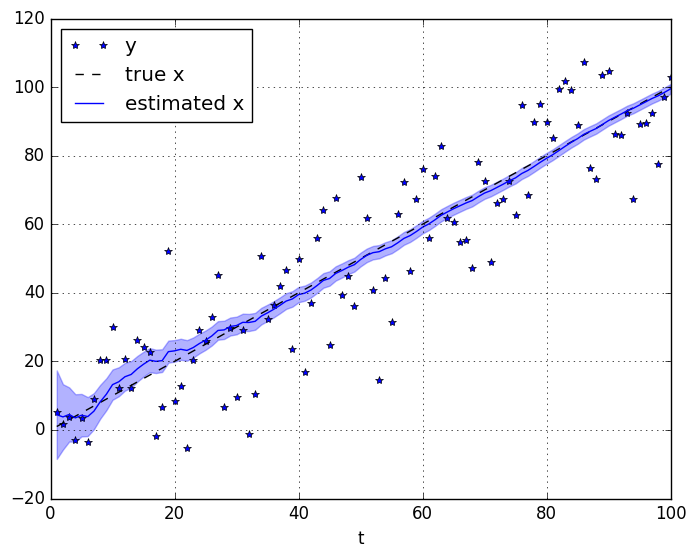

In [6]:
using PyPlot

plot(collect(1:n_samples), y, "b*", label="y")
plot(collect(1:n_samples), x, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");